### Imports


In [1]:
import os
import matplotlib.pyplot as plt
import polars as pl
import polars.selectors as cs
import numpy as np
import seaborn as sns
import plotly.express as px
import statsmodels.formula.api as smf
from uatk_spc.reader import SPCReaderParquet as SPCReader

### 1. Load an example region and explore data structure

As an example, load the SPC output for the Oxford-Cambridge arc region.


In [2]:
path = "../../data/output/special/2020"
region = "oxford_cambridge_arc"

Read from parquet and JSON


In [3]:
spc = SPCReader(path, region, backend="polars")

Show households dataframe


In [4]:
spc.households.head()

id,msoa,oa,members,details
u64,str,str,list[u64],struct[8]
0,"""E02003599""","""E00088035""","[0, 1, 2]","{""E02003599_0001"",6,4,null,5,true,5,2}"
1,"""E02003599""","""E00088045""","[3, 4, 5]","{""E02003599_0002"",4,2,null,6,true,2,2}"
2,"""E02003599""","""E00088033""",[6],"{""E02003599_0003"",8,3,null,2,true,4,1}"
3,"""E02003599""","""E00088052""","[7, 8, 9]","{""E02003599_0004"",5,3,null,5,true,4,0}"
4,"""E02003599""","""E00088040""",[10],"{""E02003599_0005"",6,2,null,6,true,4,0}"


In [5]:
spc.summary("households")

{'id': UInt64,
 'msoa': Utf8,
 'oa': Utf8,
 'members': List(UInt64),
 'details': Struct([Field('hid', Utf8), Field('nssec8', Int32), Field('accommodation_type', Int32), Field('communal_type', Int32), Field('num_rooms', UInt64), Field('central_heat', Boolean), Field('tenure', Int32), Field('num_cars', UInt64)])}

Show people dataframe


In [6]:
spc.summary("people")

{'id': UInt64,
 'household': UInt64,
 'workplace': UInt64,
 'location': Struct([Field('x', Float32), Field('y', Float32)]),
 'identifiers': Struct([Field('orig_pid', Utf8), Field('id_tus_hh', Int64), Field('id_tus_p', Int64), Field('pid_hs', Int64)]),
 'demographics': Struct([Field('sex', Int32), Field('age_years', UInt32), Field('ethnicity', Int32), Field('nssec8', Int32)]),
 'employment': Struct([Field('sic1d2007', Utf8), Field('sic2d2007', UInt64), Field('soc2010', UInt64), Field('pwkstat', Int32), Field('salary_yearly', Float32), Field('salary_hourly', Float32)]),
 'health': Struct([Field('bmi', Float32), Field('has_cardiovascular_disease', Boolean), Field('has_diabetes', Boolean), Field('has_high_blood_pressure', Boolean), Field('number_medications', UInt64), Field('self_assessed_health', Int32), Field('life_satisfaction', Int32)]),
 'events': Struct([Field('sport', Float32), Field('rugby', Float32), Field('concert_m', Float32), Field('concert_f', Float32), Field('concert_ms', Flo

In [7]:
spc.people.head()

id,household,workplace,location,identifiers,demographics,employment,health,events,weekday_diaries,weekend_diaries
u64,u64,u64,struct[2],struct[4],struct[4],struct[6],struct[7],struct[7],list[u64],list[u64]
0,0,null,"{-0.292946,52.133789}","{""E02003599_0001_001"",11180818,1,2904017}","{2,40,1,6}","{""C"",30,8133,7,null,null}","{37.280968,false,false,false,null,1,3}","{0.255,0.09435,0.016746,0.039074,1.024287,2.390004,0.15741}","[1030, 1260, 5319]","[1031, 1261, 5318]"
1,0,88,"{-0.292946,52.133789}","{""E02003599_0001_002"",14061013,2,2905699}","{1,39,1,1}","{""M"",69,1132,1,127906.320312,70.278198}","{35.771095,false,false,false,null,2,3}","{0.255,0.3213,0.070199,0.030085,2.254896,0.966384,0.15741}","[2832, 7805, … 14038]","[2833, 7804, … 14039]"
2,0,null,"{-0.292946,52.133789}","{""E02003599_0001_003"",16230603,4,2909186}","{2,7,1,null}","{null,null,null,0,null,null}","{null,false,false,false,null,1,null}","{0.257,0.09509,0.013041,0.030429,0.000854,0.001993,0.107325}","[107, 453, … 16247]","[106, 454, … 16246]"
3,1,null,"{-0.292673,52.131351}","{""E02003599_0002_001"",18151205,2,2905565}","{1,66,1,4}","{""O"",84,3313,6,null,null}","{34.354729,true,true,true,4,4,3}","{0.239,0.15057,2.1016e-14,9.0070e-15,0.34922,0.149666,0.15741}","[513, 1819, … 15923]","[514, 1818, … 15924]"
4,1,48941,"{-0.292673,52.131351}","{""E02003599_0002_002"",11090209,1,2902895}","{2,60,1,1}","{""P"",85,1135,1,64961.53125,33.76379}","{20.597435,false,false,false,null,3,null}","{0.268,0.19832,5.6552e-11,1.3196e-10,0.41975,0.979416,0.160325}","[538, 7588, … 14060]","[537, 7589, … 14061]"


Show venues


In [8]:
spc.venues_per_activity.head()

id,activity,location,urn
u64,str,struct[2],str
0,"""Retail""","{-0.203788,51.981995}",null
1,"""Retail""","{-0.522467,51.903172}",null
2,"""Retail""","{-1.28335,51.669636}",null
3,"""Retail""","{-1.279668,51.672077}",null
4,"""Retail""","{-1.309456,51.66703}",null


Show time use diaries


In [9]:
spc.time_use_diaries.head()

uid,weekday,day_type,month,pworkhome,phomeother,pwork,pschool,pshop,pservices,pleisure,pescort,ptransport,phome_total,pnothome_total,punknown_total,pmwalk,pmcycle,pmprivate,pmpublic,pmunknown,sex,age35g,nssec8,pwkstat
str,bool,i32,u32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,u32,i32,i32
"""11011202_1_0""",false,3,12,0.0,0.82639,0.0,0.0,0.0625,0.0,0.09028,0.0,0.02083,0.82639,0.17361,0.0,0.0,0.0,1.0,0.0,0.0,2,13,4,1
"""11011202_1_1""",true,3,12,0.0,0.79166,0.0,0.0,0.04167,0.0,0.125,0.0,0.04167,0.79166,0.20834,0.0,0.0,0.0,1.0,0.0,0.0,2,13,4,1
"""11011202_4_1""",true,2,12,0.0,0.61111,0.0,0.27778,0.0,0.0,0.0,0.0,0.11111,0.61111,0.38889,0.0,0.0625,0.0,0.0625,0.875,0.0625,1,6,null,0
"""11011202_4_0""",false,3,12,0.0,0.80556,0.0,0.01389,0.14583,0.0,0.03472,0.0,0.0,0.80556,0.19444,0.0,0.0,0.0,0.0,0.0,0.0,1,6,null,0
"""11011203_1_0""",false,3,12,0.0,0.90972,0.0,0.0,0.0,0.0,0.04167,0.0,0.04861,0.90972,0.09028,0.0,0.41667,0.0,0.91667,0.0,0.08333,1,19,1,6


Show info per MSOA field (example population)


In [10]:
spc.info_per_msoa[list(spc.info_per_msoa.keys())[0]]["population"]

5956

Example of a summary to see columns


In [11]:
# Show summary of people dataframe
spc.summary("people")

{'id': UInt64,
 'household': UInt64,
 'workplace': UInt64,
 'location': Struct([Field('x', Float32), Field('y', Float32)]),
 'identifiers': Struct([Field('orig_pid', Utf8), Field('id_tus_hh', Int64), Field('id_tus_p', Int64), Field('pid_hs', Int64)]),
 'demographics': Struct([Field('sex', Int32), Field('age_years', UInt32), Field('ethnicity', Int32), Field('nssec8', Int32)]),
 'employment': Struct([Field('sic1d2007', Utf8), Field('sic2d2007', UInt64), Field('soc2010', UInt64), Field('pwkstat', Int32), Field('salary_yearly', Float32), Field('salary_hourly', Float32)]),
 'health': Struct([Field('bmi', Float32), Field('has_cardiovascular_disease', Boolean), Field('has_diabetes', Boolean), Field('has_high_blood_pressure', Boolean), Field('number_medications', UInt64), Field('self_assessed_health', Int32), Field('life_satisfaction', Int32)]),
 'events': Struct([Field('sport', Float32), Field('rugby', Float32), Field('concert_m', Float32), Field('concert_f', Float32), Field('concert_ms', Flo

Plot venues in region


In [12]:
for filter_work in [False]:
    # for filter_work in [True]:
    # Plot all non-work venues
    if filter_work:
        df = spc.venues_per_activity.unnest("location")
    else:
        df = spc.venues_per_activity.unnest("location").filter(
            pl.col("activity") != "Work"
        )
    print(df)
    px.set_mapbox_access_token(os.getenv("MAPBOX_KEY"))
    fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", color="activity")
    fig.show()

shape: (962, 5)
┌─────┬─────────────────┬───────────┬───────────┬────────┐
│ id  ┆ activity        ┆ longitude ┆ latitude  ┆ urn    │
│ --- ┆ ---             ┆ ---       ┆ ---       ┆ ---    │
│ u64 ┆ str             ┆ f32       ┆ f32       ┆ str    │
╞═════╪═════════════════╪═══════════╪═══════════╪════════╡
│ 0   ┆ Retail          ┆ -0.203788 ┆ 51.981995 ┆ null   │
│ 1   ┆ Retail          ┆ -0.522467 ┆ 51.903172 ┆ null   │
│ 2   ┆ Retail          ┆ -1.28335  ┆ 51.669636 ┆ null   │
│ 3   ┆ Retail          ┆ -1.279668 ┆ 51.672077 ┆ null   │
│ …   ┆ …               ┆ …         ┆ …         ┆ …      │
│ 227 ┆ SecondarySchool ┆ -0.588381 ┆ 51.520817 ┆ 146820 │
│ 228 ┆ SecondarySchool ┆ -0.917678 ┆ 51.454231 ┆ 110062 │
│ 229 ┆ SecondarySchool ┆ -1.058186 ┆ 51.455093 ┆ 110063 │
│ 230 ┆ SecondarySchool ┆ -0.290272 ┆ 52.13784  ┆ 109669 │
└─────┴─────────────────┴───────────┴───────────┴────────┘


### 2. Explore demographic and health data


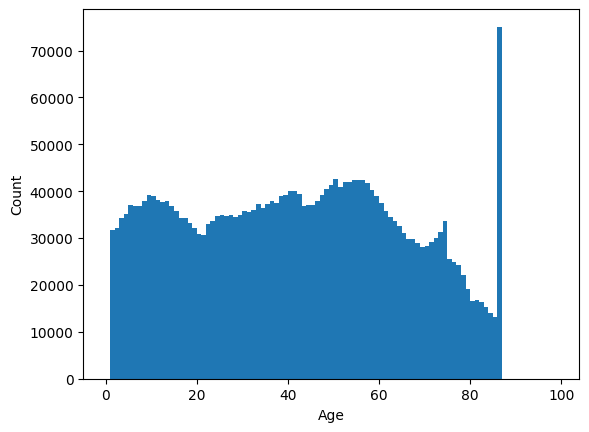

In [13]:
# Plot Age
plt.hist(
    spc.people.unnest("demographics").select("age_years"), bins=np.arange(0, 100, 1)
)
plt.gca().set(xlabel="Age", ylabel="Count")
plt.show()

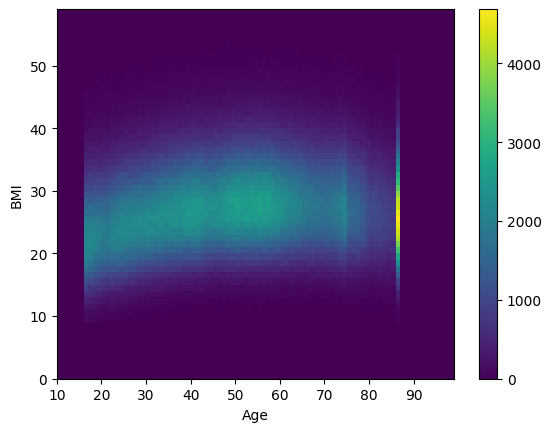

In [14]:
# Plot 2D hist of Age and BMI
age_bmi = (
    spc.people.unnest("demographics")
    .unnest("health")
    .select(["age_years", "bmi"])
    .filter(pl.col("bmi") != None)
    .to_numpy()
)
plt.hist2d(age_bmi[:, 0], age_bmi[:, 1], bins=[np.arange(10, 100), np.arange(0, 60)])
plt.gca().set(xlabel="Age", ylabel="BMI")
plt.colorbar()
plt.show()

#### 2.2 Combine with weekday diaries

**Question: Are weekday activities related to health features?**

Pick some features to explore, merge and aggregate


In [15]:
# Merge and aggregate
features = {"health": ["bmi"], "demographics": ["age_years"]}
merged = spc.merge_people_and_time_use_diaries(features, "weekday_diaries")
# List of activities
activities = merged.select(cs.starts_with("pm") | cs.matches("pleisure")).columns
# Mean per person across all diaries
merged_agg = (
    merged.select(["id"] + activities + features["health"] + features["demographics"])
    .groupby(["id"], maintain_order=True)
    .mean()
)

In [16]:
merged_agg.head()

id,pmwalk,pmcycle,pmprivate,pmpublic,pmunknown,pleisure,bmi,age_years
u64,f32,f32,f32,f32,f32,f32,f32,f64
0,0.589743,0.0,0.923077,0.0,0.076923,0.071757,37.280968,40.0
1,0.066667,0.0,0.612347,0.31124,0.076412,0.020832,35.771095,39.0
2,0.254998,0.028444,0.746524,0.036875,0.171729,0.064013,null,7.0
3,0.135747,0.0,0.711916,0.153226,0.023747,0.123456,34.354733,66.0
4,0.245088,0.0,0.892572,0.0,0.107428,0.05729,20.597435,60.0


##### Activity and Age


Look specifically at `pleisure` ("Proportion of the day spent doing outdoors leisure activities"), see [data schema](https://github.com/alan-turing-institute/uatk-spc/blob/main/synthpop.proto#L389).


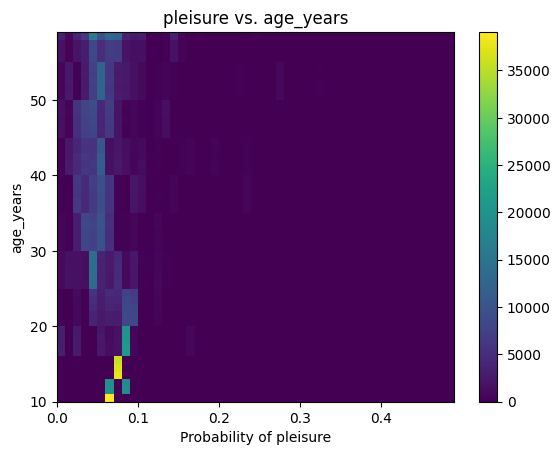

In [17]:
feature = features["demographics"][0]
q = 0.00
# activities = ["pmwalk", "pmprivate", "pleisure"]
activities = ["pleisure"]
for activity in activities:
    data = (
        merged_agg.select([activity, feature])
        .filter(pl.col(feature) != None)
        .to_numpy()
    )
    plt.hist2d(
        data[:, 0],
        data[:, 1],
        bins=[
            np.arange(np.quantile(data[:, 0], q), np.quantile(data[:, 0], 1 - q), 0.01),
            np.arange(10, 60),
        ],
    )
    plt.colorbar()
    plt.gca().set(
        title=f"{activity} vs. {feature}",
        xlabel=f"Probability of {activity}",
        ylabel=f"{feature}",
    )
    plt.show()

#### Activity and BMI


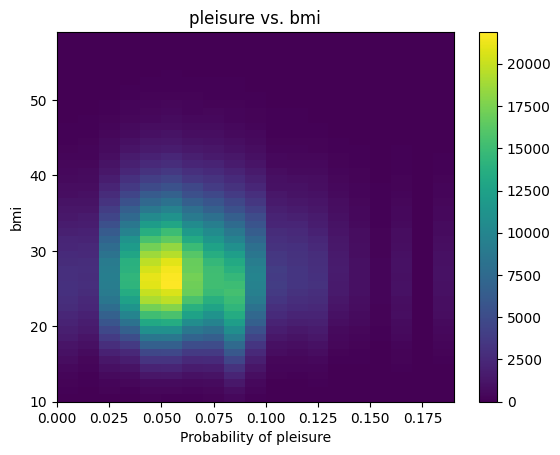

In [18]:
feature = features["health"][0]
q = 0.01
for activity in activities:
    data = (
        merged_agg.select([activity, feature])
        .filter(pl.col(feature) != None)
        .to_numpy()
    )
    plt.hist2d(
        data[:, 0],
        data[:, 1],
        bins=[
            np.arange(np.quantile(data[:, 0], q), np.quantile(data[:, 0], 1 - q), 0.01),
            np.arange(10, 60),
        ],
    )
    plt.colorbar()
    plt.gca().set(
        title=f"{activity} vs. {feature}",
        xlabel=f"Probability of {activity}",
        ylabel=f"{feature}",
    )
    plt.show()

How are age and BMI predictive of `pleisure` activity in a logistic regression?


In [19]:
cols = ["age_years", "bmi", "pleisure"]
results = smf.logit(
    "pleisure_bin ~ age_years + bmi",
    data=merged_agg.select(cols)
    .with_columns(pleisure_bin=(pl.col("pleisure") != 0.0).mul(1.0))
    .to_pandas(),
).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.072151
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           pleisure_bin   No. Observations:              2404743
Model:                          Logit   Df Residuals:                  2404740
Method:                           MLE   Df Model:                            2
Date:                Sun, 15 Oct 2023   Pseudo R-squ.:               0.0003936
Time:                        15:44:10   Log-Likelihood:            -1.7350e+05
converged:                       True   LL-Null:                   -1.7357e+05
Covariance Type:            nonrobust   LLR p-value:                 2.128e-30
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1045      0.026    158.923      0.000       4.054       4.155
age_years      0.0033      0.000     11.448      0.000       0.003       0.004
bmi            0.0005      0.001      0.583      0.560      -0.001       0.002
==============================================================================
"""

### 3. Comparison of two regions

Multiple readers can be created to allow comparison of different region's populations.


In [20]:
oxford_cambridge_arc = SPCReader(
    "../../data/output/special/2020", "oxford_cambridge_arc"
)
northwest_transpennine = SPCReader(
    "../../data/output/special/2020", "northwest_transpennine"
)

In [21]:
def combine(left: pl.DataFrame, right: pl.DataFrame, label_left: str, label_right: str):
    """Construct combined table with people and households and two regions"""
    combined = pl.concat(
        [
            left.with_columns(region=pl.lit(label_left)),
            right.with_columns(region=pl.lit(label_right)),
        ]
    )
    return (
        combined.unnest("demographics")
        .unnest("health")
        .select(pl.all().exclude("nssec8"))
        .unnest("details")
        .unnest("employment")
    )

Make combined dataframe


In [22]:
left_region, right_region = "Oxford-Cambridge Arc", "Northwest Transpennine"
combined = combine(
    oxford_cambridge_arc.merge_people_and_households(),
    northwest_transpennine.merge_people_and_households(),
    left_region,
    right_region,
)

Examine columns


In [23]:
dict(zip(combined.columns, combined.dtypes))

{'id': UInt64,
 'household': UInt64,
 'workplace': UInt64,
 'location': Struct([Field('x', Float32), Field('y', Float32)]),
 'orig_pid': Utf8,
 'id_tus_hh': Int64,
 'id_tus_p': Int64,
 'pid_hs': Int64,
 'sex': Int32,
 'age_years': UInt32,
 'ethnicity': Int32,
 'sic1d2007': Utf8,
 'sic2d2007': UInt64,
 'soc2010': UInt64,
 'pwkstat': Int32,
 'salary_yearly': Float32,
 'salary_hourly': Float32,
 'bmi': Float32,
 'has_cardiovascular_disease': Boolean,
 'has_diabetes': Boolean,
 'has_high_blood_pressure': Boolean,
 'number_medications': UInt64,
 'self_assessed_health': Int32,
 'life_satisfaction': Int32,
 'events': Struct([Field('sport', Float32), Field('rugby', Float32), Field('concert_m', Float32), Field('concert_f', Float32), Field('concert_ms', Float32), Field('concert_fs', Float32), Field('museum', Float32)]),
 'weekday_diaries': List(UInt64),
 'weekend_diaries': List(UInt64),
 'msoa': Utf8,
 'oa': Utf8,
 'members': List(UInt64),
 'hid': Utf8,
 'nssec8': Int32,
 'accommodation_type': I

In [24]:
# Summarise by region/sex
combined.groupby(["region", "sex"]).mean().select(
    ["region", "sex", "age_years", "num_cars", "central_heat"]
).pivot(
    index=["region"],
    columns=["sex"],
    values=["num_cars", "age_years", "central_heat"],
    aggregate_function="mean",
)

region,num_cars_sex_1,num_cars_sex_2,age_years_sex_1,age_years_sex_2,central_heat_sex_1,central_heat_sex_2
str,f64,f64,f64,f64,f64,f64
"""Oxford-Cambrid…",1.270312,1.271535,40.654502,42.371398,0.983909,0.983677
"""Northwest Tran…",0.95265,0.958843,39.106131,40.80725,0.96819,0.96772


**Question: how do salaries in the two regions compare? And are a subset of features predictive?**


Histogram of yearly salaries for two regions


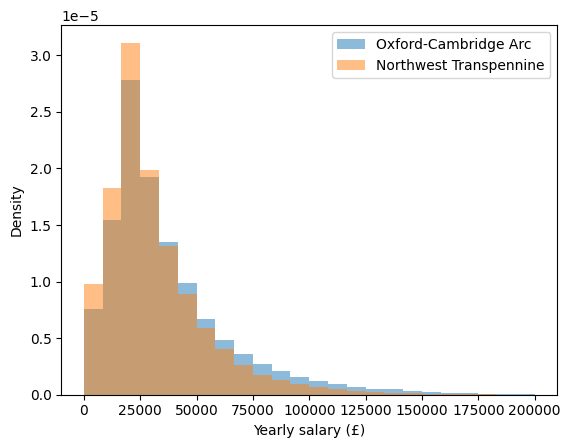

In [25]:
fig, ax = plt.subplots(1, 1)
bins = np.linspace(0, 200000, 25, endpoint=True)
ax.hist(
    combined.filter(pl.col("region") == left_region).select("salary_yearly"),
    alpha=0.5,
    bins=bins,
    label=left_region,
    density=True,
)
ax.hist(
    combined.filter(pl.col("region") == right_region).select("salary_yearly"),
    alpha=0.5,
    bins=bins,
    label=right_region,
    density=True,
)
ax.legend()
# ax.set(ylim=(0, 0.0001))
ax.set(xlabel="Yearly salary (£)", ylabel="Density")
plt.show()

A simple OLS regression model for salary with predictors from household and demographic features.


In [26]:
cols = ["region", "bmi", "has_diabetes", "num_cars", "central_heat", "salary_yearly"]
results = smf.ols(
    "salary_yearly ~ region + bmi + has_diabetes + num_cars + central_heat",
    data=combined.select(cols).to_pandas(),
).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          salary_yearly   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                 1.490e+04
Date:                Sun, 15 Oct 2023   Prob (F-statistic):               0.00
Time:                        15:45:00   Log-Likelihood:            -4.5542e+07
No. Observations:             3942475   AIC:                         9.108e+07
Df Residuals:                 3942469   BIC:                         9.109e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         2.6e+04     93.349    278.488      0.000    2.58e+04    2.62e+04
region[T.Oxford-Cambridge Arc]  4744.7235     28.042    169.201      0.000    4689.762    4799.685
has_diabetes[T.True]             821.3429     57.298     14.335      0.000     709.041     933.644
central_heat[T.True]           -1160.3595     76.929    -15.083      0.000   -1311.138   -1009.581
bmi                              143.0334      1.898     75.363      0.000     139.314     146.753
num_cars                        2740.2506     17.161    159.679      0.000    2706.616    2773.886
==============================================================================
Omnibus:                  1860299.831   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13475352.180
Skew:                           2.156   Prob(JB):                         0.00
Kurtosis:                      10.965   Cond. No.                         258.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""